<a href="https://colab.research.google.com/github/el-grudge/Introduction-to-Adversarial-Attacks/blob/main/Introduction_to_Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main

## Setup

In [ ]:
!pip install olympic

In [ ]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import json
import numpy as np
import olympic
import matplotlib.pyplot as plt
from argparse import Namespace
from tqdm.notebook import tqdm

from resnet import *
from utils import *

import sys
sys.path.append('./adversarial/')
from functional import boundary, iterated_fgsm, local_search, fgsm, pgd

from google.colab import files

In [ ]:
args = Namespace(
    # Seed
    seed = 832,
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # Network parameters
    batch_size = 64,
    num_epochs = 50,
    learning_rate = 0.001,
    # Adversary parameters
    epsilon = .03,
    adversarial_training = False,
    adversarial_testing = False,
)

In [ ]:
np.random.seed(args.seed)
torch.cuda.manual_seed_all(args.seed) if torch.cuda.is_available() else torch.manual_seed(args.seed)

In [ ]:
train, val = get_datasets()
train_loader, val_loader = get_dataloaders(train, val, args.batch_size)

Files already downloaded and verified


## Natural Training

In [ ]:
# Model
net_args = {
    "block": ResidualBlock,
    "channels": train_loader.dataset[0][0].shape[0],
    "layers": [2, 2, 2],
    "num_classes": 10
    }
model = ResNet(**net_args).to(args.device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=args.learning_rate)
scheduler = ReduceLROnPlateau(optimizer, patience = 5)

In [ ]:
# Train the model
train_acc = []
val_acc = []

for epoch in range(args.num_epochs):
  model.train()
  total = 0
  correct = 0

  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    outputs, loss = forward_pass(model, images, labels, loss_fn, optimizer)
    
    if args.adversarial_training:
      # Create adversarial examples
      images_adv = fgsm_attack(images, args.epsilon, images.grad.data)
      
      # Train on adversarial images
      outputs, loss = forward_pass(model, images_adv, labels, loss_fn, optimizer)
    
    pred = torch.max(outputs.data, 1)[1]  
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  
  # Test the model
  model.eval()
  total = 0
  correct = 0
  
  for images, labels in val_loader:
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    outputs = model(images)
    val_loss = loss_fn(outputs, labels)
    
    if args.adversarial_testing:
      val_loss.backward()
      perturbed_images = fgsm_attack(images, args.epsilon, images.grad.data)
      
      outputs = model(perturbed_images.to(args.device))
      val_loss = loss_fn(outputs, labels)
	  
    pred = torch.max(outputs.data, 1)[1] # save the prediction of the adversarial sample
    total += labels.size(0)
    correct += (pred == labels).sum().item()

  val_acc.append(correct / total)
  
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {'loss':loss.item(),
               'acc':train_acc[epoch],
               'val_loss': val_loss.item(),
               'val_acc':val_acc[epoch],
               'LR':curr_lr}

  pbar.set_postfix(pbar_dict)

In [ ]:
# Save models
torch.save(model, './data/models/model_cifar_resnet18_epochs=50_natural.pt')
# Download models
files.download('./data/models/model_cifar_resnet18_epochs=50_natural.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
olympic.evaluate(model, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(args.device), batch[1].to(args.device)))

{'val_accuracy': 0.8415}

In [ ]:
train_results = {'train_acc': train_acc, 'val_acc': val_acc}

with open('./data/results/train_results.json', 'w') as f:
    json.dump(train_results, f)

No handles with labels found to put in legend.


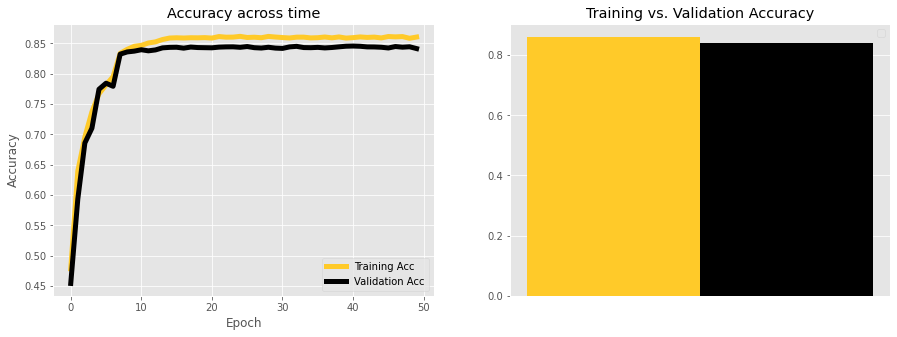

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(train_results['train_acc'], label='Training Acc', color='#ffca29', linewidth=5)
    axes[0].plot(train_results['val_acc'], label='Validation Acc', color='black', linewidth=5)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, train_results['train_acc'][-1], 0.2, color='#ffca29')
    axes[1].bar(index+0.2, train_results['val_acc'][-1], 0.2, color='black')
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('./data/images/naturalTraining.png')

In [ ]:
files.download('./data/images/naturalTraining1.png')
files.download('./data/results/train_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load natural models
model = torch.load('./data/models/model_cifar_resnet18_epochs=50_natural.pt')

In [ ]:
olympic.evaluate(model, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(args.device), batch[1].to(args.device)))

{'val_accuracy': 0.8415}

## Attack with FGSM

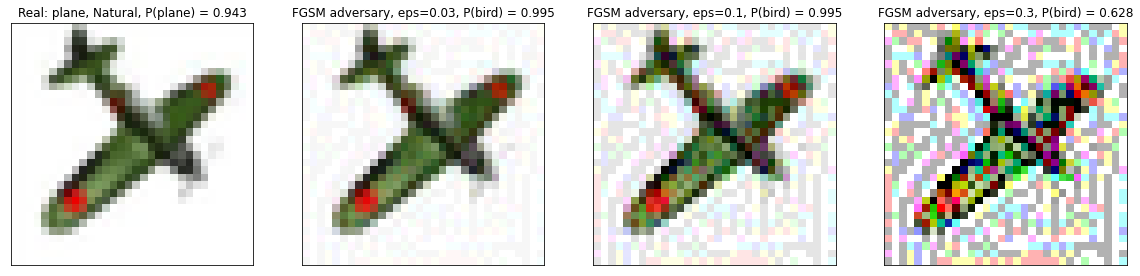

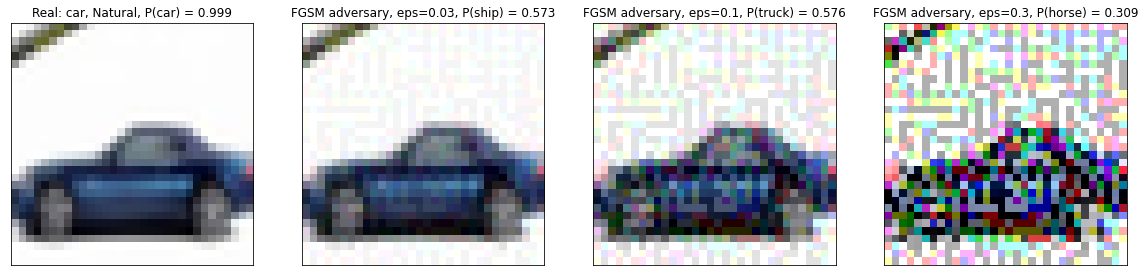

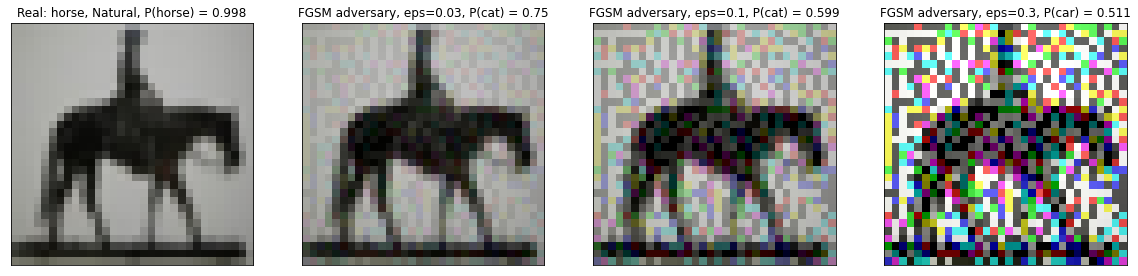

In [ ]:
visualise_adversarial_examples_fgsm(model, *val[98], args.device)
visualise_adversarial_examples_fgsm(model, *val[105], args.device)
visualise_adversarial_examples_fgsm(model, *val[288], args.device)

## Quantifying adversarial accuracy

In [ ]:
fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
fgsm_acc = []
for eps in fgsm_attack_range:
    fgsm_acc.append(evaluate_against_adversary(model, val_loader, k=1, eps=eps, step=1, norm='fgsm', device=args.device))

In [ ]:
fgsm_accuracy_natural = {'fgsm_attack_range': list(fgsm_attack_range), 'fgsm_acc': fgsm_acc}

with open('./data/results/fgsm_accuracy_natural.json', 'w') as f:
    json.dump(fgsm_accuracy_natural, f)

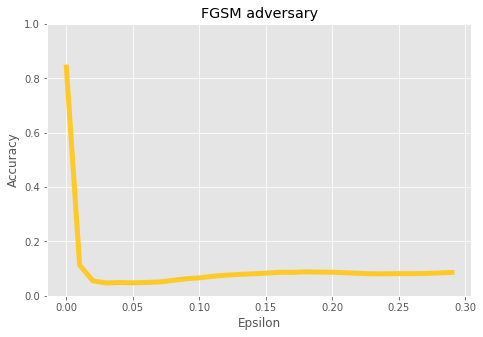

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('FGSM adversary')
    axes.plot(fgsm_accuracy_natural['fgsm_attack_range'], fgsm_accuracy_natural['fgsm_acc'], color='#ffca29', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/images/quantifyingAdversary.png')

In [ ]:
files.download('./data/images/quantifyingAdversary.png')
files.download('./data/results/fgsm_accuracy_natural.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Adversarial Training (FGSM)

In [ ]:
# Model
net_args = {
    "block": ResidualBlock,
    "channels": train_loader.dataset[0][0].shape[0],
    "layers": [2, 2, 2],
    "num_classes": 10
}
adv_model_fgsm = ResNet(**net_args).to(args.device)

args.adversarial_training = True
args.learning_rate = 0.001

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(adv_model_fgsm.parameters(), lr=args.learning_rate)
scheduler = ReduceLROnPlateau(optimizer, patience = 5)

In [ ]:
# Train the model
train_acc = []
train_adv_acc = []
val_acc = []
val_adv_acc = []

for epoch in range(args.num_epochs):
  adv_model_fgsm.train()
  total = 0
  correct = 0
  correct_adv = 0

  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    outputs, loss = forward_pass(adv_model_fgsm, images, labels, loss_fn, optimizer)
    
    total += labels.size(0)
    pred = torch.max(outputs.data, 1)[1]
    correct += (pred == labels).sum().item()

    if args.adversarial_training:
      # Create adversarial examples
      images_adv = fgsm_attack(images, args.epsilon, images.grad.data)
      
      # Train on adversarial images
      outputs, loss = forward_pass(adv_model_fgsm, images_adv, labels, loss_fn, optimizer)
    
    pred_adv = torch.max(outputs.data, 1)[1]  
    correct_adv += (pred_adv == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  train_adv_acc.append(correct_adv / total)
  
  # Test the model
  adv_model_fgsm.eval()
  total = 0
  correct = 0
  correct_adv = 0
  
  for images, labels in val_loader:
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    outputs = adv_model_fgsm(images)
    
    total += labels.size(0)
    pred = torch.max(outputs.data, 1)[1] # save the prediction of the adversarial sample
    correct += (pred == labels).sum().item()
    
    if args.adversarial_testing:
      val_loss.backward()
      perturbed_images = fgsm_attack(images, args.epsilon, images.grad.data)
      
      outputs = adv_model_fgsm(perturbed_images.to(args.device))
    
    val_loss = loss_fn(outputs, labels)
	  
    pred_adv = torch.max(outputs.data, 1)[1] # save the prediction of the adversarial sample
    correct_adv += (pred_adv == labels).sum().item()

  val_acc.append(correct / total)
  val_adv_acc.append(correct_adv / total)
  
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {'loss':loss.item(),
               'acc':train_acc[epoch],
               'adv_acc':train_adv_acc[epoch],
               'val_loss': val_loss.item(),
               'val_acc':val_acc[epoch],
               'adv_val_acc':val_adv_acc[epoch],
               'LR':curr_lr}

  pbar.set_postfix(pbar_dict)

In [ ]:
# Save hardened models
torch.save(adv_model_fgsm, './data/models/adv_model_fgsm_cifar_resnet18_epochs=50_natural.pt')
# Download hardened models
files.download('./data/models/adv_model_fgsm_cifar_resnet18_epochs=50_natural.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
olympic.evaluate(adv_model_fgsm, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(args.device), batch[1].to(args.device)))

{'val_accuracy': 0.7366}

In [ ]:
adv_train_results = {'train_acc': train_acc, 'train_adv_acc': train_adv_acc, 'val_acc': val_acc}

with open('./data/results/adv_train_results.json', 'w') as f:
    json.dump(adv_train_results, f)

No handles with labels found to put in legend.


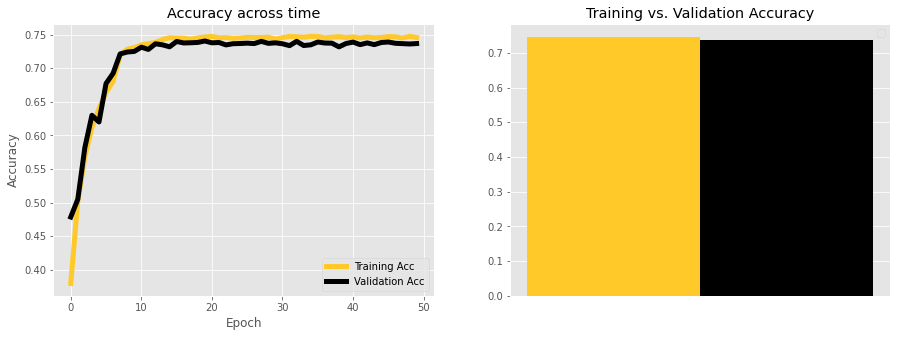

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(adv_train_results['train_acc'], label='Training Acc', color='#ffca29', linewidth=5)
    # axes[0].plot(adv_train_results['train_adv_acc'], label='Training Adversarial Acc', color='#be9430', linewidth=5)
    axes[0].plot(adv_train_results['val_acc'], label='Validation Acc', color='black', linewidth=5)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend() 

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, adv_train_results['train_acc'][-1], 0.2, color='#ffca29')
    axes[1].bar(index+0.2, adv_train_results['val_acc'][-1], 0.2, color='black')
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('./data/images/adversarialTraining.png')

In [ ]:
files.download('./data/images/adversarialTraining.png')
files.download('./data/results/adv_train_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load hardened models
adv_model_fgsm = torch.load('./data/models/adv_model_fgsm_cifar_resnet18_epochs=50_natural.pt')

In [ ]:
olympic.evaluate(adv_model_fgsm, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(args.device), batch[1].to(args.device)))

{'val_accuracy': 0.7366}

## Natural vs. Robust Accuracy

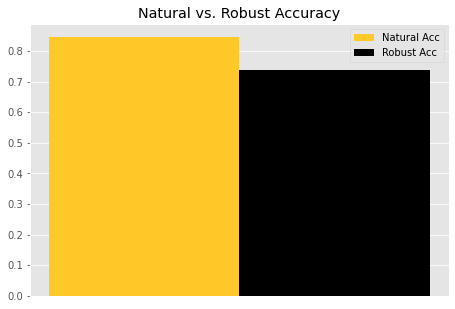

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 1, figsize=(7.5,5))
    plt.figure(figsize=(14,7))
    
    axes.set_title('Natural vs. Robust Accuracy')
    axes.bar(index, train_results['val_acc'], 0.2, color='#ffca29', label='Natural Acc')
    axes.bar(index+0.2, adv_train_results['val_acc'][-1], 0.2, color='black', label='Robust Acc')
    axes.set_xticks([])
    axes.legend()
    
    plt.show()
    plt.savefig('./data/images/compareAccuracy.png')

In [ ]:
files.download('./data/images/compareAccuracy.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate robust model

In [ ]:
fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
fgsm_acc = []
for eps in fgsm_attack_range:
    fgsm_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=1, eps=eps, step=1, norm='fgsm', device=args.device))

In [ ]:
fgsm_accuracy_robust = {'fgsm_attack_range': list(fgsm_attack_range), 'fgsm_acc': fgsm_acc}

with open('./data/results/fgsm_accuracy_robust.json', 'w') as f:
    json.dump(fgsm_accuracy_robust, f)

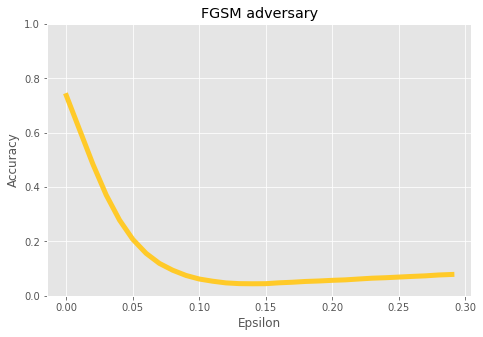

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('FGSM adversary')
    axes.plot(fgsm_accuracy_robust['fgsm_attack_range'], fgsm_accuracy_robust['fgsm_acc'], color='#ffca29', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/images/evalutingRobustness.png')

In [ ]:
files.download('./data/images/evalutingRobustness.png')
files.download('./data/results/fgsm_accuracy_robust.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Attack with Iterated-FGSM

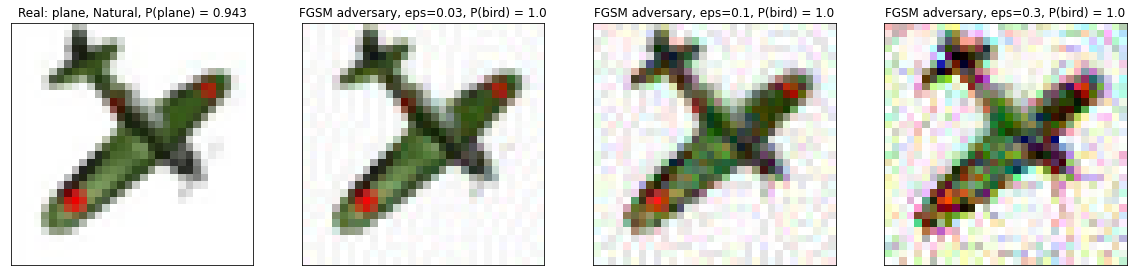

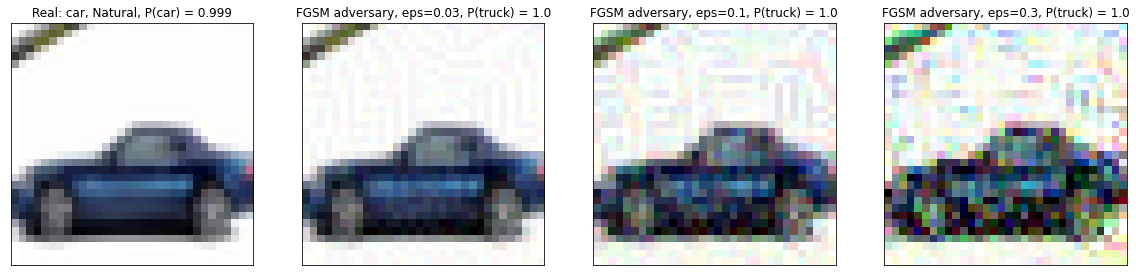

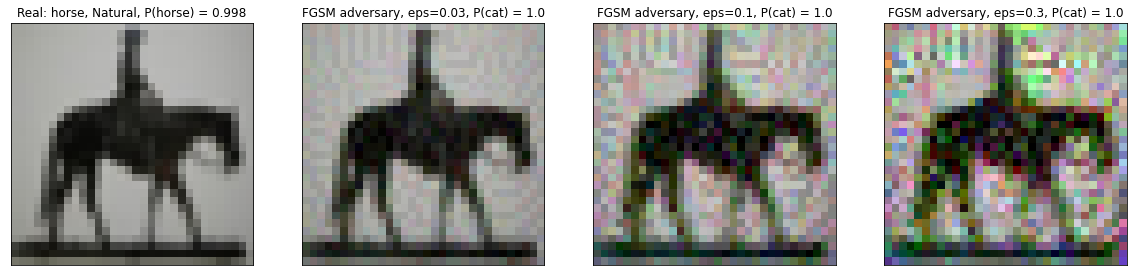

In [ ]:
visualise_adversarial_examples_ifgsm(model, *val[98], args.device)
visualise_adversarial_examples_ifgsm(model, *val[105], args.device)
visualise_adversarial_examples_ifgsm(model, *val[288], args.device)

## Quantifying adversarial accuracy with Iterated-FGSM

In [ ]:
iter_fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
iter_fgsm_acc = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=80, eps=eps, step=0.01, norm='i-fgsm', device=args.device))

In [ ]:
iter_fgsm_accuracy_robust = {'iter_fgsm_attack_range': list(iter_fgsm_attack_range), 'iter_fgsm_acc': iter_fgsm_acc}

with open('./data/results/iter_fgsm_accuracy_robust.json', 'w') as f:
    json.dump(iter_fgsm_accuracy_robust, f)

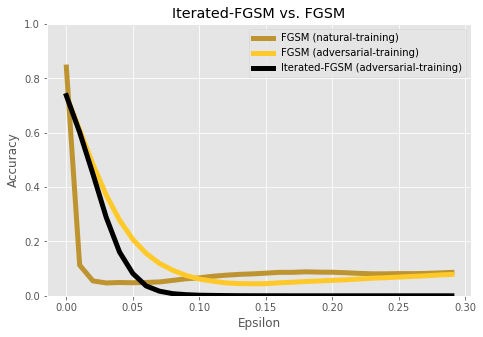

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('Iterated-FGSM vs. FGSM')
    axes.plot(fgsm_accuracy_natural['fgsm_attack_range'], fgsm_accuracy_natural['fgsm_acc'], label='FGSM (natural-training)', color='#be9430', linewidth=5)
    axes.plot(fgsm_accuracy_robust['fgsm_attack_range'], fgsm_accuracy_robust['fgsm_acc'], label='FGSM (adversarial-training)', color='#ffca29', linewidth=5)
    axes.plot(iter_fgsm_accuracy_robust['iter_fgsm_attack_range'], iter_fgsm_accuracy_robust['iter_fgsm_acc'], label='Iterated-FGSM (adversarial-training)', color='black', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    axes.legend()
    
    plt.show()
    plt.savefig('./data/images/iter_fgsm_accuracy_robust.png')

In [ ]:
files.download('./data/images/iter_fgsm_accuracy_robust.png')
files.download('./data/results/iter_fgsm_accuracy_robust.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('utils.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>